In [26]:
from os.path import join
import json
import csv
import glob
import os

import rpy2.rinterface
from pandas import read_csv, DataFrame, Series
from qiime2 import Artifact
from statsmodels.stats.weightstats import DescrStatsW
from scipy.stats import t, sem
from IPython.display import Image

In [27]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [28]:
%reload_ext rpy2.ipython

In [29]:
%%R 
library(ggplot2)
library(grid)

In [30]:
empo3_dir = '/home/qiime2/empo-3'

In [31]:
columns = ['sample type', 'sample', 'fold']
data = {c:[] for c in columns}
for type_dir in glob.glob(join(empo3_dir, '*')):
    if not os.path.exists(join(type_dir, 'results')):
        continue
    type_ = os.path.basename(type_dir)
    for fold_dir in glob.glob(join(type_dir, 'tmp', 'fold-*')):
        _, fold = fold_dir.rsplit('-', 1)
        with open(join(fold_dir, 'sample_test.json')) as fh:
            samples = json.load(fh)
        data['sample'].extend(samples)
        data['sample type'].extend([type_]*len(samples))
        data['fold'].extend([fold]*len(samples))
folds = DataFrame(data)

In [32]:
abundances = read_csv(join(empo3_dir, 'abundances.tsv'), sep='\t')
abundances = abundances.set_index(['sample type', 'sample'])

In [33]:
prf = read_csv(join(empo3_dir, 'eval_taxa_prf.tsv'), sep='\t')

In [34]:
prf = prf.join(abundances, ['sample type', 'sample'])

In [35]:
folds.head()

,sample type,sample,fold
0,sediment-non-saline,807.C.F.11.b.61303,3
1,sediment-non-saline,1883.2009.305.Crump.Artic.LTREB.main.lane3.NoI...,3
2,sediment-non-saline,1883.2011.289.Crump.Artic.LTREB.main.lane4.NoI...,3
3,sediment-non-saline,807.E.S.12.a.61303,3
4,sediment-non-saline,1883.2008.303.Crump.Artic.LTREB.main.lane2.NoI...,3


In [36]:
folds = folds.set_index(['sample type', 'sample'])
prf = prf.join(folds, ['sample type', 'sample'])
prf.head()

,Unnamed: 0,level,Precision,Recall,F-measure,method,class weights,sample type,sample,abundance,fold
0,0,1,0.999059,0.998871,0.998965,weighted,RandomForest/4-4-sqrt-10-3-0.9,sediment-non-saline,1883.2009.15.Crump.Artic.LTREB.main.lane3.NoIn...,5314,0
1,1,2,0.963235,0.024652,0.048073,weighted,RandomForest/4-4-sqrt-10-3-0.9,sediment-non-saline,1883.2009.15.Crump.Artic.LTREB.main.lane3.NoIn...,5314,0
2,2,3,0.000000,0.000000,0.000000,weighted,RandomForest/4-4-sqrt-10-3-0.9,sediment-non-saline,1883.2009.15.Crump.Artic.LTREB.main.lane3.NoIn...,5314,0
3,3,4,0.000000,0.000000,0.000000,weighted,RandomForest/4-4-sqrt-10-3-0.9,sediment-non-saline,1883.2009.15.Crump.Artic.LTREB.main.lane3.NoIn...,5314,0
4,4,5,0.000000,0.000000,0.000000,weighted,RandomForest/4-4-sqrt-10-3-0.9,sediment-non-saline,1883.2009.15.Crump.Artic.LTREB.main.lane3.NoIn...,5314,0


In [39]:
prf = prf[prf['method'] == 'weighted']
level7 = prf[(prf['level'] == 7)]

In [40]:
level7.head()

,Unnamed: 0,level,Precision,Recall,F-measure,method,class weights,sample type,sample,abundance,fold
6,6,7,0.0,0.0,0.0,weighted,RandomForest/4-4-sqrt-10-3-0.9,sediment-non-saline,1883.2009.15.Crump.Artic.LTREB.main.lane3.NoIn...,5314,0
20,6,7,0.0,0.0,0.0,weighted,RandomForest/4-4-sqrt-10-3-0.9,sediment-non-saline,1883.2011.279.Crump.Artic.LTREB.main.lane4.NoI...,4554,1
34,6,7,0.0,0.0,0.0,weighted,RandomForest/4-4-sqrt-10-3-0.9,sediment-non-saline,10308.J2.2.BEACH.S.61733,101366,3
48,6,7,0.0,0.0,0.0,weighted,RandomForest/4-4-sqrt-10-3-0.9,sediment-non-saline,1883.2008.336.Crump.Artic.LTREB.main.lane2.NoI...,255,1
62,6,7,0.0,0.0,0.0,weighted,RandomForest/4-4-sqrt-10-3-0.9,sediment-non-saline,1883.2008.341.Crump.Artic.LTREB.main.lane2.NoI...,398,3


In [41]:
grouped = level7.groupby(['sample type', 'class weights', 'fold', 'level'])
def weighted_stats(x):
    d1 = DescrStatsW(x['F-measure'], weights=x['abundance'])
    return Series([d1.mean], index=['mean'])
figure1 = grouped.apply(weighted_stats)
figure1.reset_index(inplace=True)

In [42]:
grouped = figure1.groupby(['sample type', 'class weights', 'level'])
def weighted_stats(x):
    mu = x['mean'].mean()
    se = sem(x['mean'])
    lower, upper = mu-se, mu+se
    return Series([mu, lower, upper], index=['mean', 'lower', 'upper'])
figure1 = grouped.apply(weighted_stats)
figure1.reset_index(inplace=True)

In [45]:
prf = figure1

In [49]:
df = prf.sort_values(by="mean")
# 102648 rows in total
df['F-measure'] = df['mean']
df

,sample type,class weights,level,mean,lower,upper,F-measure
1,sediment-non-saline,RandomForest/10-4-log2-10-1-0.9,7,0.000000,0.000000e+00,0.000000,0.000000
23,sediment-non-saline,RandomForest/30-8-log2-100-1-0.9,7,0.000000,0.000000e+00,0.000000,0.000000
3,sediment-non-saline,RandomForest/12-4-log2-10-3-0.9,7,0.000000,0.000000e+00,0.000000,0.000000
4,sediment-non-saline,RandomForest/13-4-log2-100-1-0.7,7,0.000000,0.000000e+00,0.000000,0.000000
5,sediment-non-saline,RandomForest/14-4-log2-100-1-0.9,7,0.000000,0.000000e+00,0.000000,0.000000
6,sediment-non-saline,RandomForest/15-4-log2-10-3-0.7,7,0.000000,0.000000e+00,0.000000,0.000000
7,sediment-non-saline,RandomForest/16-4-log2-100-3-0.9,7,0.000000,0.000000e+00,0.000000,0.000000
25,sediment-non-saline,RandomForest/32-8-log2-100-3-0.9,7,0.000000,0.000000e+00,0.000000,0.000000
20,sediment-non-saline,RandomForest/28-8-log2-10-3-0.9,7,0.000811,0.000000e+00,0.001621,0.000811
35,sediment-non-saline,RandomForest/8-4-sqrt-100-3-0.9,7,0.001141,-2.168404e-19,0.002282,0.001141


In [50]:
# separating naive_bayes and random_forest

def search_naive_bayes(name):
    if 'Naive' in name:
        return True
    else:
        return False
    
def search_random_forest(name):
    if 'Random' in name:
        return True
    else:
        return False
    
random_forest = df[df['class weights'].apply(lambda x: not search_naive_bayes(x))]
naive_bayes = df[df['class weights'].apply(lambda x: search_naive_bayes(x))]

In [51]:
# value 1 is just a dummy
# dummy in 'max_features' must be str, otherwise it fails.
random_forest.insert(loc=0, column='max_depth', value=1)
random_forest.insert(loc=0, column='max_features', value='a')
random_forest.insert(loc=0, column='n_estimators', value=1)
random_forest.insert(loc=0, column='min_samples_leaf', value=1)

In [52]:
# iterate through data frame to update parameters
for i, r in random_forest.iterrows():
    r1 = r['class weights'].split('-')
    max_depth = str(r1[1])
    max_features = str(r1[2])
    n_estimators = str(r1[3])
    min_samples_leaf = str(r1[4])
    random_forest.at[i,'max_depth'] = max_depth
    random_forest.at[i,'max_features'] = max_features
    random_forest.at[i,'n_estimators'] = n_estimators
    random_forest.at[i,'min_samples_leaf'] = min_samples_leaf

In [53]:
random_forest

,min_samples_leaf,n_estimators,max_features,max_depth,sample type,class weights,level,mean,lower,upper,F-measure
1,1,10,log2,4,sediment-non-saline,RandomForest/10-4-log2-10-1-0.9,7,0.000000,0.000000e+00,0.000000,0.000000
23,1,100,log2,8,sediment-non-saline,RandomForest/30-8-log2-100-1-0.9,7,0.000000,0.000000e+00,0.000000,0.000000
3,3,10,log2,4,sediment-non-saline,RandomForest/12-4-log2-10-3-0.9,7,0.000000,0.000000e+00,0.000000,0.000000
4,1,100,log2,4,sediment-non-saline,RandomForest/13-4-log2-100-1-0.7,7,0.000000,0.000000e+00,0.000000,0.000000
5,1,100,log2,4,sediment-non-saline,RandomForest/14-4-log2-100-1-0.9,7,0.000000,0.000000e+00,0.000000,0.000000
6,3,10,log2,4,sediment-non-saline,RandomForest/15-4-log2-10-3-0.7,7,0.000000,0.000000e+00,0.000000,0.000000
7,3,100,log2,4,sediment-non-saline,RandomForest/16-4-log2-100-3-0.9,7,0.000000,0.000000e+00,0.000000,0.000000
25,3,100,log2,8,sediment-non-saline,RandomForest/32-8-log2-100-3-0.9,7,0.000000,0.000000e+00,0.000000,0.000000
20,3,10,log2,8,sediment-non-saline,RandomForest/28-8-log2-10-3-0.9,7,0.000811,0.000000e+00,0.001621,0.000811
35,3,100,sqrt,4,sediment-non-saline,RandomForest/8-4-sqrt-100-3-0.9,7,0.001141,-2.168404e-19,0.002282,0.001141


##### Naive_bayes.count = 5264
##### Random_forest.count = 97384

In [76]:
# separating random_forest 0.7, 0.9 and naive_bayes 0.7, 0.9

def search_confidence_0_7(confidence):
    if '0.7' in confidence:
        return True
    else:
        return False
    
def search_confidence_0_9(confidence):
    if '0.9' in confidence:
        return True
    else:
        return False

# assign in these variables
random_forest_0_7 = random_forest[random_forest['class weights'].apply(lambda x: search_confidence_0_7(x))]
random_forest_0_9 = random_forest[random_forest['class weights'].apply(lambda x: search_confidence_0_9(x))]

naive_bayes_0_7 = naive_bayes[naive_bayes['class weights'].apply(lambda x: search_confidence_0_7(x))]
naive_bayes_0_9 = naive_bayes[naive_bayes['class weights'].apply(lambda x: search_confidence_0_9(x))]

#### random_forest_0_7 = 47376
#### random_forest_0_9 = 50008
#### total = 97384

#### naive_bayes_0_7 = 2632
#### naive_bayes_0_9 = 2632
#### total = 5264

#### Please note that there are 4 classifiers with max_depth = 16,  while 12 classifiers for max_depth = 4, 8 each

In [55]:
# if you want to have a look in file
# random_forest_0_7.to_excel('random_forest_0_7.xlsx', sheet_name='Sheet1')

In [67]:
naive_bayes

,sample type,class weights,level,mean,lower,upper,F-measure
38,sediment-non-saline,RandomForest/Naive_Bayse_0.9,7,0.892832,0.890577,0.895087,0.892832
37,sediment-non-saline,RandomForest/Naive_Bayse_0.7,7,0.904495,0.902066,0.906924,0.904495


In [68]:
random_forest_0_7.sort_values(by="n_estimators")

,min_samples_leaf,n_estimators,max_features,max_depth,sample type,class weights,level,mean,lower,upper,F-measure
28,3,10,sqrt,16,sediment-non-saline,RandomForest/35-16-sqrt-10-3-0.7,7,0.452631,4.420045e-01,0.463257,0.452631
6,3,10,log2,4,sediment-non-saline,RandomForest/15-4-log2-10-3-0.7,7,0.000000,0.000000e+00,0.000000,0.000000
2,3,10,log2,4,sediment-non-saline,RandomForest/11-4-log2-10-3-0.7,7,0.002762,4.336809e-19,0.005524,0.002762
36,1,10,log2,4,sediment-non-saline,RandomForest/9-4-log2-10-1-0.7,7,0.002959,8.776818e-05,0.005829,0.002959
19,3,10,log2,8,sediment-non-saline,RandomForest/27-8-log2-10-3-0.7,7,0.027408,2.030851e-02,0.034507,0.027408
8,1,10,sqrt,8,sediment-non-saline,RandomForest/17-8-sqrt-10-1-0.7,7,0.212575,2.015744e-01,0.223576,0.212575
0,1,10,sqrt,4,sediment-non-saline,RandomForest/1-4-sqrt-10-1-0.7,7,0.046442,2.511535e-02,0.067768,0.046442
26,1,10,sqrt,16,sediment-non-saline,RandomForest/33-16-sqrt-10-1-0.7,7,0.444841,4.347035e-01,0.454979,0.444841
17,1,10,log2,8,sediment-non-saline,RandomForest/25-8-log2-10-1-0.7,7,0.058972,5.120578e-02,0.066737,0.058972
22,3,10,sqrt,4,sediment-non-saline,RandomForest/3-4-sqrt-10-3-0.7,7,0.078637,7.407063e-02,0.083204,0.078637


In [74]:
random_forest_0_7 = random_forest_0_7[random_forest_0_7['max_depth']!=16]
random_forest_0_7

,min_samples_leaf,n_estimators,max_features,max_depth,sample type,class weights,level,mean,lower,upper,F-measure
4,1,100,log2,4,sediment-non-saline,RandomForest/13-4-log2-100-1-0.7,7,0.000000,0.000000e+00,0.000000,0.000000
6,3,10,log2,4,sediment-non-saline,RandomForest/15-4-log2-10-3-0.7,7,0.000000,0.000000e+00,0.000000,0.000000
2,3,10,log2,4,sediment-non-saline,RandomForest/11-4-log2-10-3-0.7,7,0.002762,4.336809e-19,0.005524,0.002762
36,1,10,log2,4,sediment-non-saline,RandomForest/9-4-log2-10-1-0.7,7,0.002959,8.776818e-05,0.005829,0.002959
19,3,10,log2,8,sediment-non-saline,RandomForest/27-8-log2-10-3-0.7,7,0.027408,2.030851e-02,0.034507,0.027408
21,1,100,log2,8,sediment-non-saline,RandomForest/29-8-log2-100-1-0.7,7,0.032790,3.070685e-02,0.034874,0.032790
24,3,100,log2,8,sediment-non-saline,RandomForest/31-8-log2-100-3-0.7,7,0.039810,3.664363e-02,0.042976,0.039810
0,1,10,sqrt,4,sediment-non-saline,RandomForest/1-4-sqrt-10-1-0.7,7,0.046442,2.511535e-02,0.067768,0.046442
34,3,100,sqrt,4,sediment-non-saline,RandomForest/7-4-sqrt-100-3-0.7,7,0.057194,4.245380e-02,0.071934,0.057194
17,1,10,log2,8,sediment-non-saline,RandomForest/25-8-log2-10-1-0.7,7,0.058972,5.120578e-02,0.066737,0.058972


In [66]:
random_forest_0_9

,min_samples_leaf,n_estimators,max_features,max_depth,sample type,class weights,level,mean,lower,upper,F-measure
1,1,10,log2,4,sediment-non-saline,RandomForest/10-4-log2-10-1-0.9,7,0.000000,0.000000e+00,0.000000,0.000000
23,1,100,log2,8,sediment-non-saline,RandomForest/30-8-log2-100-1-0.9,7,0.000000,0.000000e+00,0.000000,0.000000
3,3,10,log2,4,sediment-non-saline,RandomForest/12-4-log2-10-3-0.9,7,0.000000,0.000000e+00,0.000000,0.000000
5,1,100,log2,4,sediment-non-saline,RandomForest/14-4-log2-100-1-0.9,7,0.000000,0.000000e+00,0.000000,0.000000
7,3,100,log2,4,sediment-non-saline,RandomForest/16-4-log2-100-3-0.9,7,0.000000,0.000000e+00,0.000000,0.000000
25,3,100,log2,8,sediment-non-saline,RandomForest/32-8-log2-100-3-0.9,7,0.000000,0.000000e+00,0.000000,0.000000
20,3,10,log2,8,sediment-non-saline,RandomForest/28-8-log2-10-3-0.9,7,0.000811,0.000000e+00,0.001621,0.000811
35,3,100,sqrt,4,sediment-non-saline,RandomForest/8-4-sqrt-100-3-0.9,7,0.001141,-2.168404e-19,0.002282,0.001141
18,1,10,log2,8,sediment-non-saline,RandomForest/26-8-log2-10-1-0.9,7,0.001694,4.550403e-04,0.002933,0.001694
33,1,100,sqrt,4,sediment-non-saline,RandomForest/6-4-sqrt-100-1-0.9,7,0.003187,7.842537e-04,0.005589,0.003187


### Seaborn and matplotlib are used for plotting.

Naive Bayse F-measure Median at 0.7 confidence = 0.9044950120858404
n_estimateors=10 F-measure Median at 0.7 confidence = 0.05897159643512634
n_estimateors=100 F-measure Median at 0.7 confidence = 0.05719386317307804


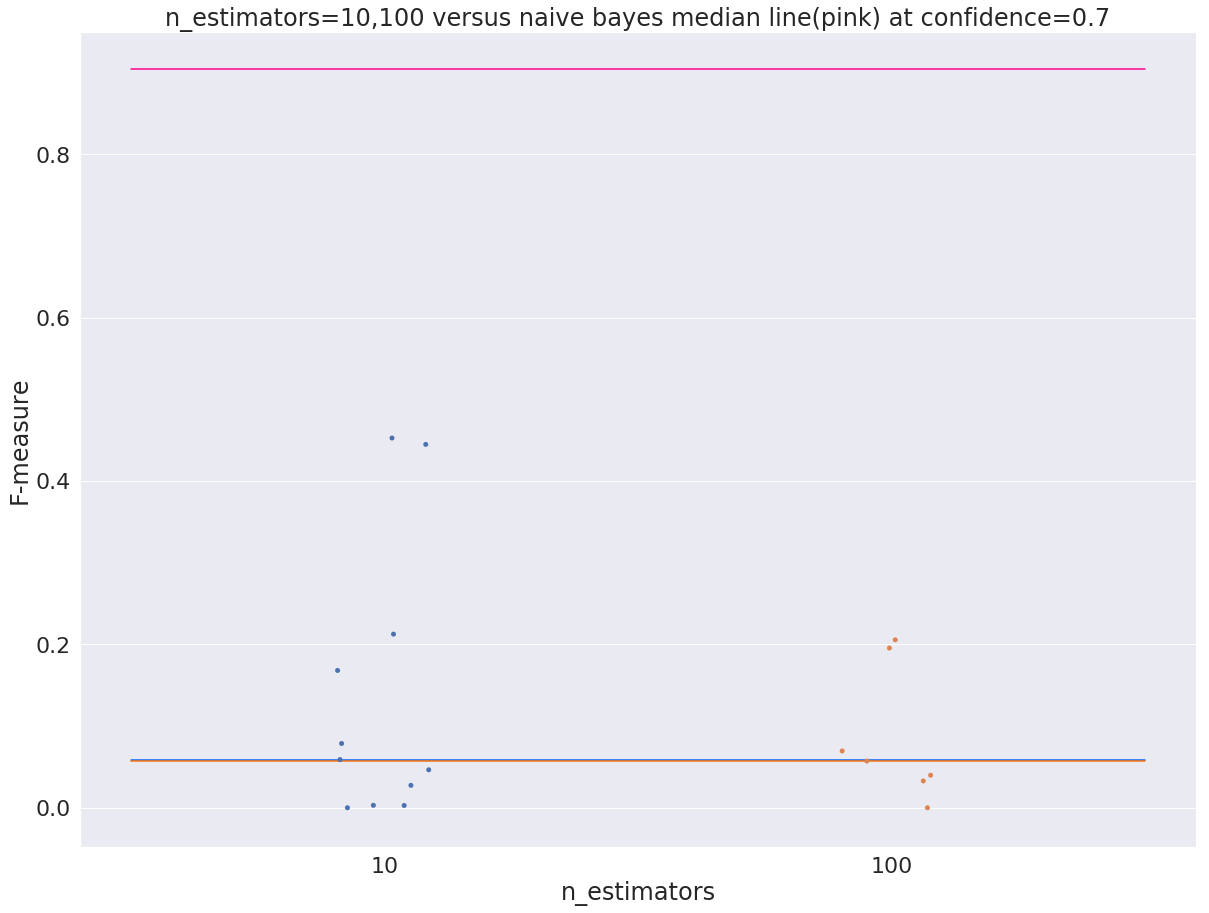

In [77]:
# naive bayes median line
nmed = naive_bayes_0_7.loc[naive_bayes_0_7['sample type'] == 'sediment-non-saline'].median()['F-measure']

# n_estimators median lines
xmed = random_forest_0_7.loc[random_forest_0_7["n_estimators"] == 10].median()['F-measure']
ymed = random_forest_0_7.loc[random_forest_0_7["n_estimators"] == 100].median()['F-measure']

# print median values of each catagory
print('Naive Bayse F-measure Median at 0.7 confidence = {0}'.format(nmed))
print('n_estimateors=10 F-measure Median at 0.7 confidence = {0}'.format(xmed))
print('n_estimateors=100 F-measure Median at 0.7 confidence = {0}'.format(ymed))


sns.stripplot(x='n_estimators', y='F-measure', data=random_forest_0_7)
sns.set(rc={'figure.figsize':(20,15)})
sns.set(font_scale=2)

x = plt.gca().axes.get_xlim()

plt.plot(x, len(x) * [xmed], sns.xkcd_rgb["bright blue"])
plt.plot(x, len(x) * [ymed], sns.xkcd_rgb["orange"])
plt.plot(x, len(x) * [nmed], sns.xkcd_rgb["hot pink"])
plt.title("n_estimators=10,100 versus naive bayes median line(pink) at confidence=0.7")
plt.show()

Naive Bayse F-measure Median at 0.9 confidence = 0.8928320369269551
n_estimateors=10 F-measure Median at 0.9 confidence = 0.011501278634985141
n_estimateors=100 F-measure Median at 0.9 confidence = 0.0011408360338504158


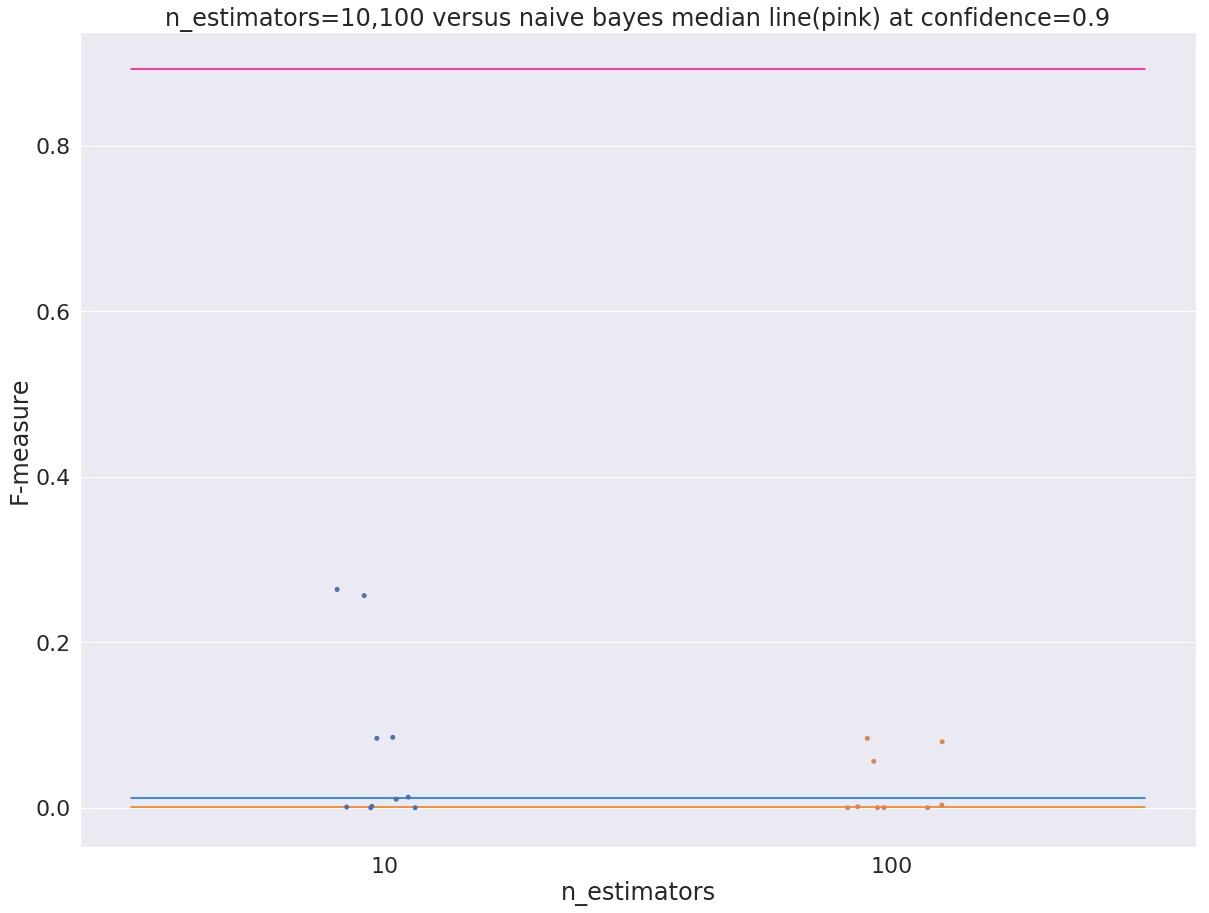

In [59]:
# naive bayes median line
nmed = naive_bayes_0_9.loc[naive_bayes_0_9['sample type'] == 'sediment-non-saline'].median()['F-measure']

# n_estimators median lines
xmed = random_forest_0_9.loc[random_forest_0_9["n_estimators"] == 10].median()['F-measure']
ymed = random_forest_0_9.loc[random_forest_0_9["n_estimators"] == 100].median()['F-measure']

# print median values of each catagory
print('Naive Bayse F-measure Median at 0.9 confidence = {0}'.format(nmed))
print('n_estimateors=10 F-measure Median at 0.9 confidence = {0}'.format(xmed))
print('n_estimateors=100 F-measure Median at 0.9 confidence = {0}'.format(ymed))


sns.stripplot(x='n_estimators', y='F-measure', data=random_forest_0_9)
sns.set(rc={'figure.figsize':(20,15)})
sns.set(font_scale=2)

x = plt.gca().axes.get_xlim()

plt.plot(x, len(x) * [xmed], sns.xkcd_rgb["bright blue"])
plt.plot(x, len(x) * [ymed], sns.xkcd_rgb["orange"])
plt.plot(x, len(x) * [nmed], sns.xkcd_rgb["hot pink"])
plt.title("n_estimators=10,100 versus naive bayes median line(pink) at confidence=0.9")
plt.show()

Naive Bayse F-measure Median at 0.7 confidence = 0.9044950120858404
max_depth=4 F-measure Median at 0.7 confidence = 0.024700118585328223
max_depth=8 F-measure Median at 0.7 confidence = 0.11353102120574114
max_depth=16 F-measure Median at 0.7 confidence = 0.4487358605046825


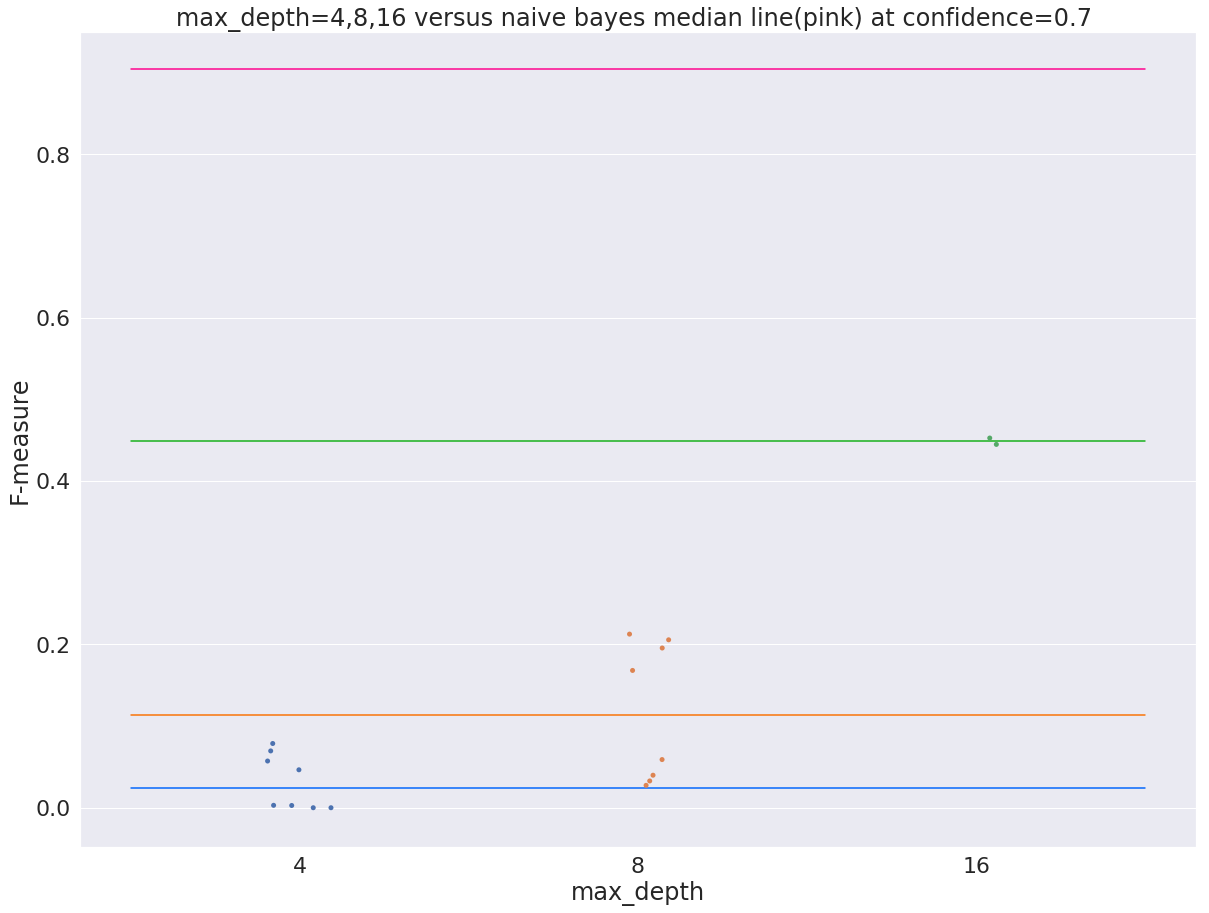

In [60]:
# naive bayes median line
nmed = naive_bayes_0_7.loc[naive_bayes_0_7['sample type'] == 'sediment-non-saline'].median()['F-measure']

# n_estimators median lines
xmed = random_forest_0_7.loc[random_forest_0_7["max_depth"] == 4].median()['F-measure']
ymed = random_forest_0_7.loc[random_forest_0_7["max_depth"] == 8].median()['F-measure']
zmed = random_forest_0_7.loc[random_forest_0_7["max_depth"] == 16].median()['F-measure']

# print median values of each catagory
print('Naive Bayse F-measure Median at 0.7 confidence = {0}'.format(nmed))
print('max_depth=4 F-measure Median at 0.7 confidence = {0}'.format(xmed))
print('max_depth=8 F-measure Median at 0.7 confidence = {0}'.format(ymed))
print('max_depth=16 F-measure Median at 0.7 confidence = {0}'.format(zmed))


sns.stripplot(x='max_depth', y='F-measure', data=random_forest_0_7)
sns.set(rc={'figure.figsize':(20,15)})
sns.set(font_scale=2)

x = plt.gca().axes.get_xlim()

plt.plot(x, len(x) * [xmed], sns.xkcd_rgb["bright blue"])
plt.plot(x, len(x) * [ymed], sns.xkcd_rgb["orange"])
plt.plot(x, len(x) * [zmed], sns.xkcd_rgb["green"])
plt.plot(x, len(x) * [nmed], sns.xkcd_rgb["hot pink"])
plt.title("max_depth=4,8,16 versus naive bayes median line(pink) at confidence=0.7 ")
plt.show()

Naive Bayse F-measure Median at 0.9 confidence = 0.8928320369269551
max_depth=4 F-measure Median at 0.9 confidence = 0.0005704180169252079
max_depth=8 F-measure Median at 0.9 confidence = 0.0406847624088678
max_depth=16 F-measure Median at 0.9 confidence = 0.25633841872925717


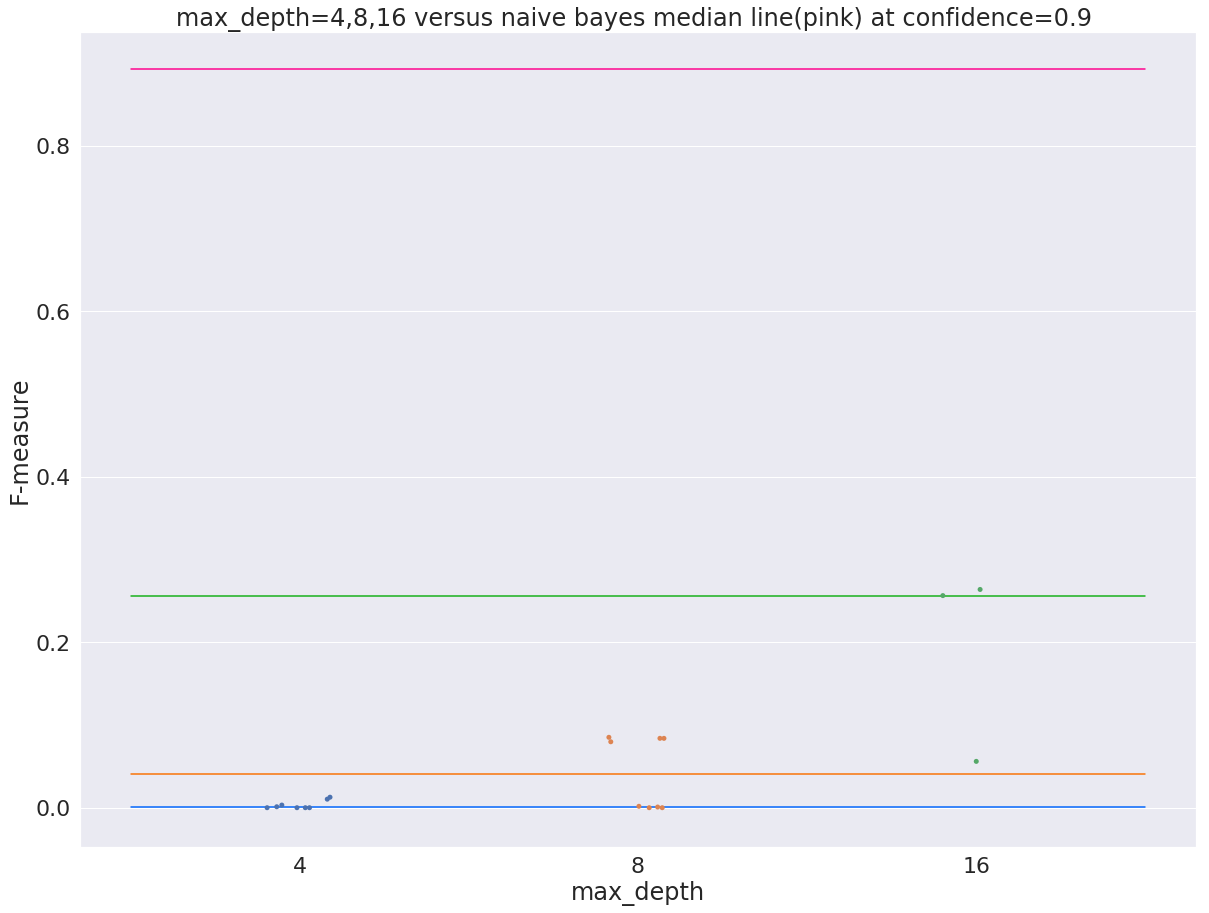

In [61]:
# naive bayes median line
nmed = naive_bayes_0_9.loc[naive_bayes_0_9['sample type'] == 'sediment-non-saline'].median()['F-measure']

# n_estimators median lines
xmed = random_forest_0_9.loc[random_forest_0_9["max_depth"] == 4].median()['F-measure']
ymed = random_forest_0_9.loc[random_forest_0_9["max_depth"] == 8].median()['F-measure']
zmed = random_forest_0_9.loc[random_forest_0_9["max_depth"] == 16].median()['F-measure']

# print median values of each catagory
print('Naive Bayse F-measure Median at 0.9 confidence = {0}'.format(nmed))
print('max_depth=4 F-measure Median at 0.9 confidence = {0}'.format(xmed))
print('max_depth=8 F-measure Median at 0.9 confidence = {0}'.format(ymed))
print('max_depth=16 F-measure Median at 0.9 confidence = {0}'.format(zmed))


sns.stripplot(x='max_depth', y='F-measure', data=random_forest_0_9)
sns.set(rc={'figure.figsize':(20,15)})
sns.set(font_scale=2)

x = plt.gca().axes.get_xlim()

plt.plot(x, len(x) * [xmed], sns.xkcd_rgb["bright blue"])
plt.plot(x, len(x) * [ymed], sns.xkcd_rgb["orange"])
plt.plot(x, len(x) * [zmed], sns.xkcd_rgb["green"])
plt.plot(x, len(x) * [nmed], sns.xkcd_rgb["hot pink"])
plt.title("max_depth=4,8,16 versus naive bayes median line(pink) at confidence=0.9 ")
plt.show()

Naive Bayse F-measure Median at 0.7 confidence = 0.9044950120858404
min_samples_leaf=1 F-measure Median at 0.7 confidence = 0.05270663062513737
min_samples_leaf=3 F-measure Median at 0.7 confidence = 0.04850190401016291


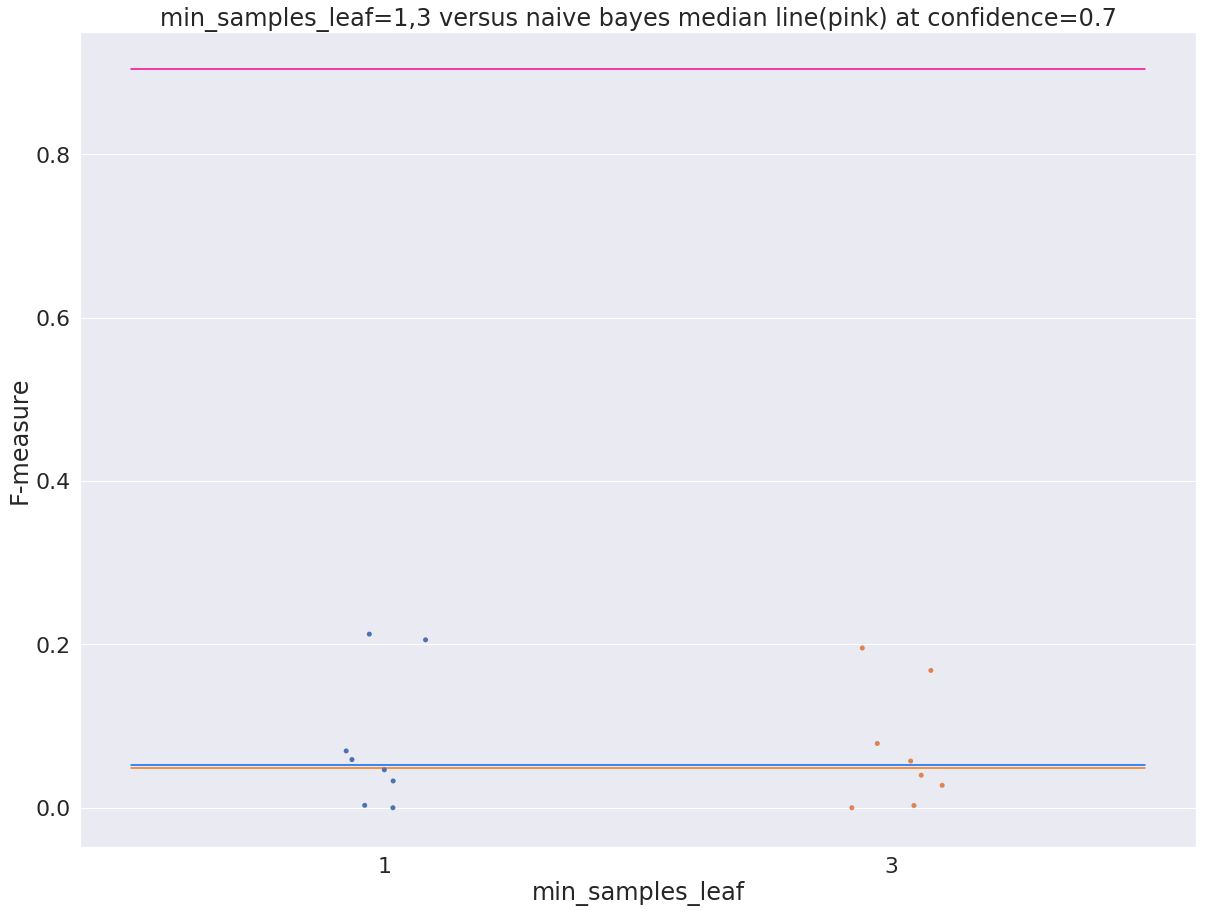

In [72]:
# naive bayes median line
nmed = naive_bayes_0_7.loc[naive_bayes_0_7['sample type'] == 'sediment-non-saline'].median()['F-measure']

# parameter median lines
xmed = random_forest_0_7.loc[random_forest_0_7["min_samples_leaf"] == 1].median()['F-measure']
ymed = random_forest_0_7.loc[random_forest_0_7["min_samples_leaf"] == 3].median()['F-measure']

# print median values of each catagory
print('Naive Bayse F-measure Median at 0.7 confidence = {0}'.format(nmed))
print('min_samples_leaf=1 F-measure Median at 0.7 confidence = {0}'.format(xmed))
print('min_samples_leaf=3 F-measure Median at 0.7 confidence = {0}'.format(ymed))


sns.stripplot(x='min_samples_leaf', y='F-measure', data=random_forest_0_7)
sns.set(rc={'figure.figsize':(20,15)})
sns.set(font_scale=2)

x = plt.gca().axes.get_xlim()

plt.plot(x, len(x) * [xmed], sns.xkcd_rgb["bright blue"])
plt.plot(x, len(x) * [ymed], sns.xkcd_rgb["orange"])
plt.plot(x, len(x) * [nmed], sns.xkcd_rgb["hot pink"])
plt.title("min_samples_leaf=1,3 versus naive bayes median line(pink) at confidence=0.7")
plt.show()

Naive Bayse F-measure Median at 0.9 confidence = 0.8928320369269551
min_samples_leaf=1 F-measure Median at 0.9 confidence = 0.0031865841553126543
min_samples_leaf=3 F-measure Median at 0.9 confidence = 0.005725825943025519


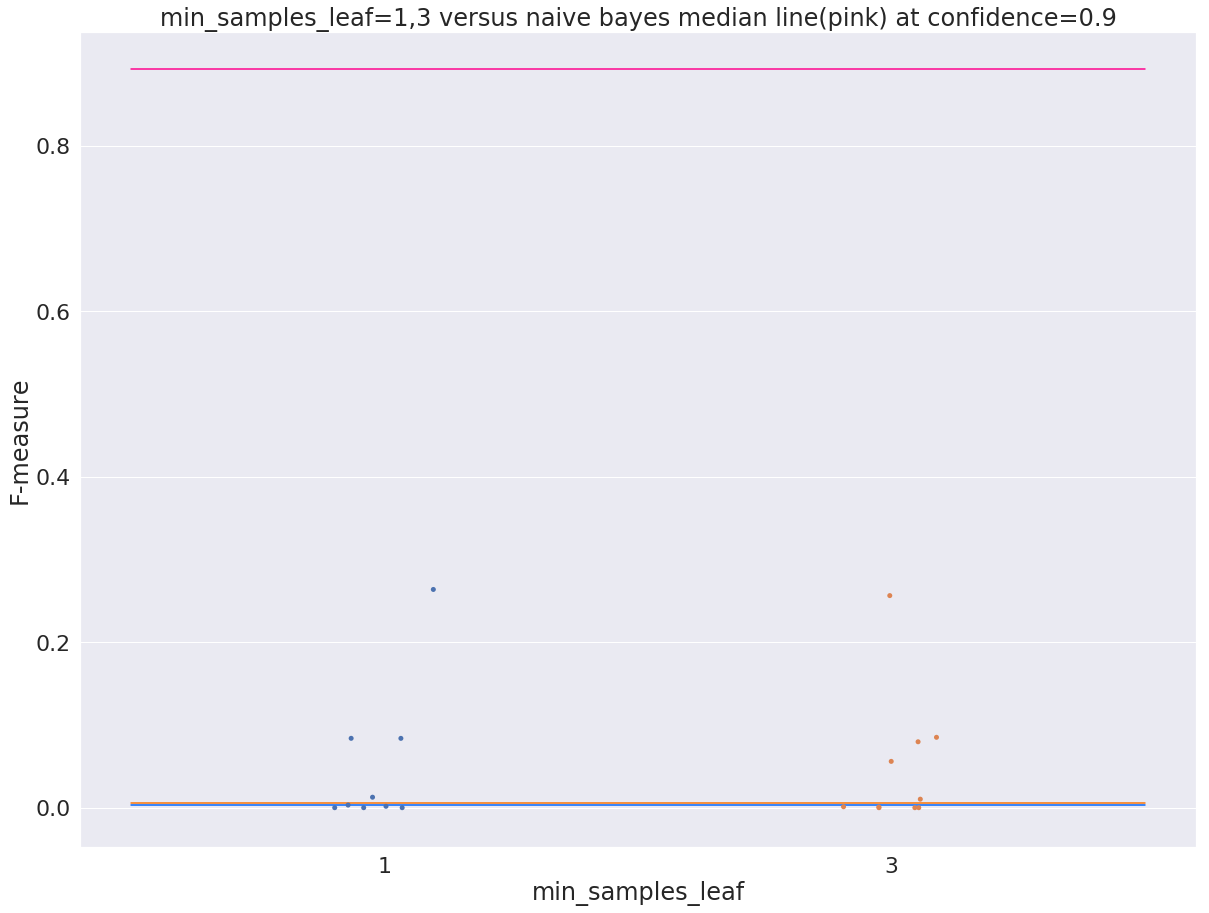

In [63]:
# naive bayes median line
nmed = naive_bayes_0_9.loc[naive_bayes_0_9['sample type'] == 'sediment-non-saline'].median()['F-measure']

# parameter median lines
xmed = random_forest_0_9.loc[random_forest_0_9["min_samples_leaf"] == 1].median()['F-measure']
ymed = random_forest_0_9.loc[random_forest_0_9["min_samples_leaf"] == 3].median()['F-measure']

# print median values of each catagory
print('Naive Bayse F-measure Median at 0.9 confidence = {0}'.format(nmed))
print('min_samples_leaf=1 F-measure Median at 0.9 confidence = {0}'.format(xmed))
print('min_samples_leaf=3 F-measure Median at 0.9 confidence = {0}'.format(ymed))


sns.stripplot(x='min_samples_leaf', y='F-measure', data=random_forest_0_9)
sns.set(rc={'figure.figsize':(20,15)})
sns.set(font_scale=2)

x = plt.gca().axes.get_xlim()

plt.plot(x, len(x) * [xmed], sns.xkcd_rgb["bright blue"])
plt.plot(x, len(x) * [ymed], sns.xkcd_rgb["orange"])
plt.plot(x, len(x) * [nmed], sns.xkcd_rgb["hot pink"])
plt.title("min_samples_leaf=1,3 versus naive bayes median line(pink) at confidence=0.9")
plt.show()

Naive Bayse F-measure Median at 0.7 confidence = 0.9044950120858404
min_samples_leaf=1 F-measure Median at 0.7 confidence = 0.015183042898761665
min_samples_leaf=3 F-measure Median at 0.7 confidence = 0.18181853444807666


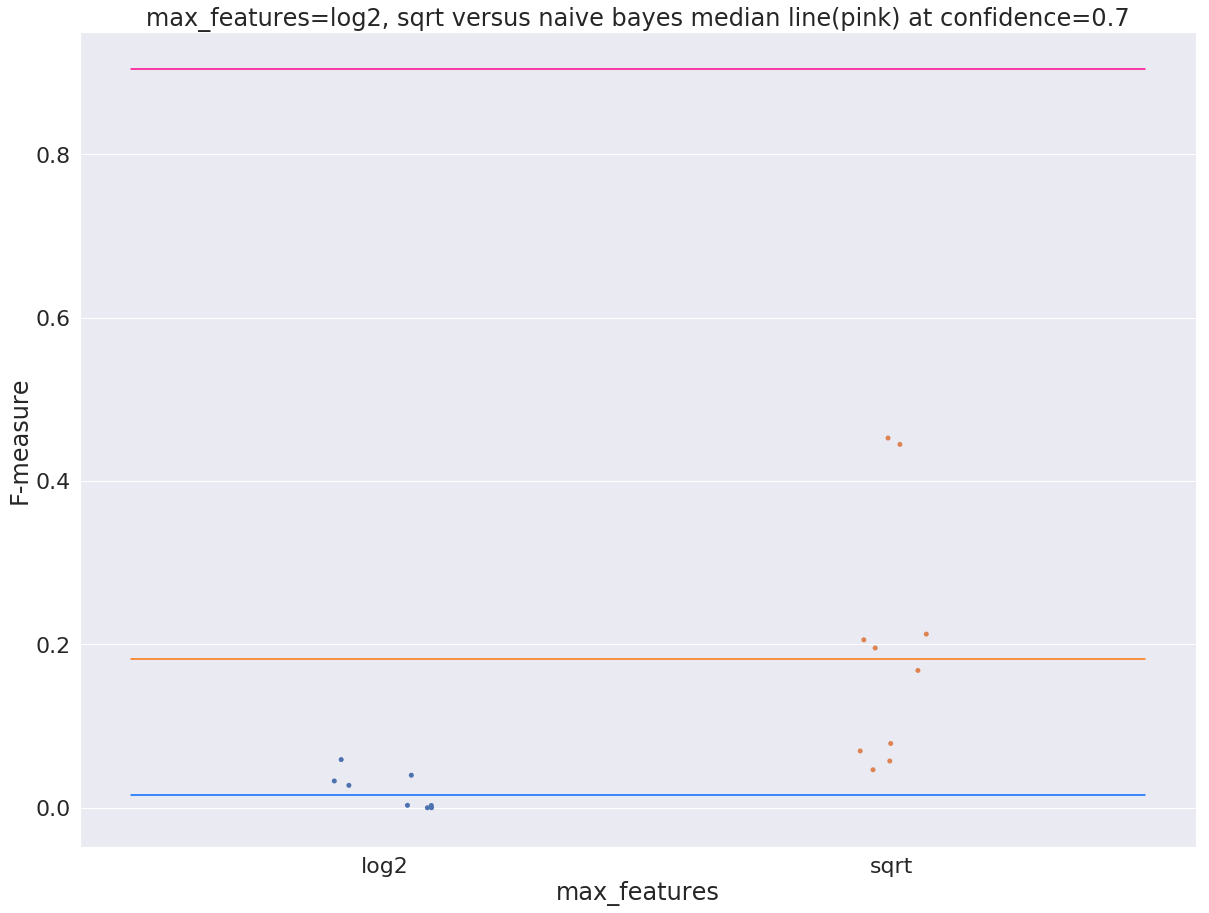

In [64]:
# naive bayes median line
nmed = naive_bayes_0_7.loc[naive_bayes_0_7['sample type'] == 'sediment-non-saline'].median()['F-measure']

# parameter median lines
xmed = random_forest_0_7.loc[random_forest_0_7["max_features"] == 'log2'].median()['F-measure']
ymed = random_forest_0_7.loc[random_forest_0_7["max_features"] == 'sqrt'].median()['F-measure']

# print median values of each catagory
print('Naive Bayse F-measure Median at 0.7 confidence = {0}'.format(nmed))
print('min_samples_leaf=1 F-measure Median at 0.7 confidence = {0}'.format(xmed))
print('min_samples_leaf=3 F-measure Median at 0.7 confidence = {0}'.format(ymed))


sns.stripplot(x='max_features', y='F-measure', data=random_forest_0_7)
sns.set(rc={'figure.figsize':(20,15)})
sns.set(font_scale=2)

x = plt.gca().axes.get_xlim()

plt.plot(x, len(x) * [xmed], sns.xkcd_rgb["bright blue"])
plt.plot(x, len(x) * [ymed], sns.xkcd_rgb["orange"])
plt.plot(x, len(x) * [nmed], sns.xkcd_rgb["hot pink"])
plt.title("max_features=log2, sqrt versus naive bayes median line(pink) at confidence=0.7")
plt.show()

Naive Bayse F-measure Median at 0.9 confidence = 0.8928320369269551
min_samples_leaf=1 F-measure Median at 0.9 confidence = 0.0
min_samples_leaf=3 F-measure Median at 0.9 confidence = 0.08174212273672513


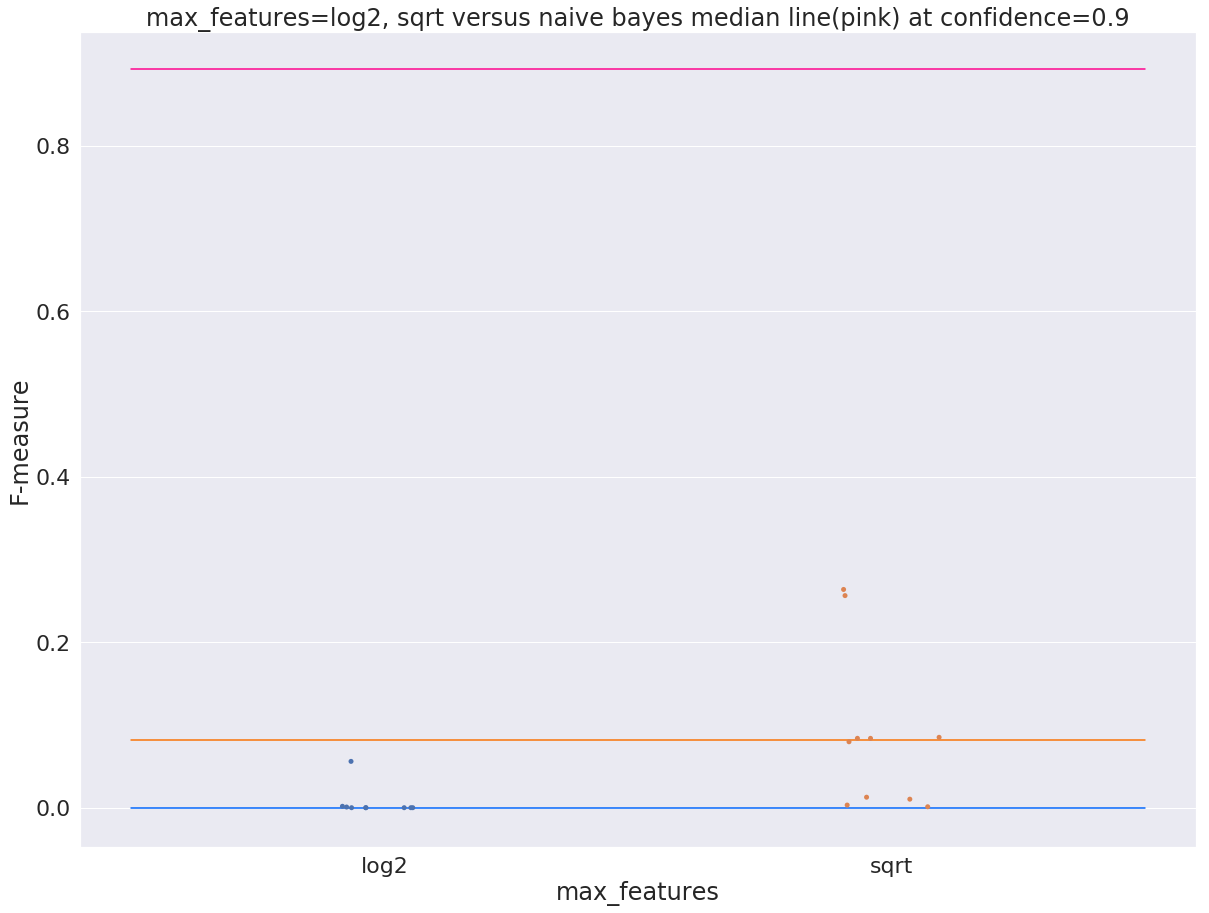

In [65]:
# naive bayes median line
nmed = naive_bayes_0_9.loc[naive_bayes_0_9['sample type'] == 'sediment-non-saline'].median()['F-measure']

# parameter median lines
xmed = random_forest_0_9.loc[random_forest_0_9["max_features"] == 'log2'].median()['F-measure']
ymed = random_forest_0_9.loc[random_forest_0_9["max_features"] == 'sqrt'].median()['F-measure']

# print median values of each catagory
print('Naive Bayse F-measure Median at 0.9 confidence = {0}'.format(nmed))
print('min_samples_leaf=1 F-measure Median at 0.9 confidence = {0}'.format(xmed))
print('min_samples_leaf=3 F-measure Median at 0.9 confidence = {0}'.format(ymed))


sns.stripplot(x='max_features', y='F-measure', data=random_forest_0_9)
sns.set(rc={'figure.figsize':(20,15)})
sns.set(font_scale=2)

x = plt.gca().axes.get_xlim()

plt.plot(x, len(x) * [xmed], sns.xkcd_rgb["bright blue"])
plt.plot(x, len(x) * [ymed], sns.xkcd_rgb["orange"])
plt.plot(x, len(x) * [nmed], sns.xkcd_rgb["hot pink"])
plt.title("max_features=log2, sqrt versus naive bayes median line(pink) at confidence=0.9")
plt.show()

In [16]:
old_labels = [
    'animal-corpus',
    'animal-distal-gut',
    'animal-proximal-gut',
    'animal-secretion',
    'animal-surface',
    'plant-corpus',
    'plant-rhizosphere',
    'sediment-non-saline',
    'soil-non-saline',
    'surface-non-saline',
    'water-non-saline',
    'sediment-saline',
    'surface-saline',
    'water-saline',
    'average', 'uniform70', 'bespoke70']
new_labels = [
    'Other'] * 14 + ['Average', 'Uniform', 'Bespoke']
for old, new in zip(old_labels, new_labels):
    figure1.loc[figure1['class weights'] == old, 'class weights'] = new
old_labels = [
    'animal-corpus',
    'animal-distal-gut',
    'animal-proximal-gut',
    'animal-secretion',
    'animal-surface',
    'plant-corpus',
    'plant-rhizosphere',
    'sediment-non-saline',
    'soil-non-saline',
    'surface-non-saline',
    'water-non-saline',
    'sediment-saline',
    'surface-saline',
    'water-saline'
]
new_labels = [
    'Animal corpus',
    'Animal distal gut',
    'Animal proximal gut',
    'Animal secretion',
    'Animal surface',
    'Plant corpus',
    'Plant rhizosphere',
    'Sediment (non-saline)',
    'Soil (non-saline)',
    'Surface (non-saline)',
    'Water (non-saline)',
    'Sediment (saline)',
    'Surface (saline)',
    'Water (saline)'
]
for old, new in zip(old_labels, new_labels):
    figure1.loc[figure1['sample type'] == old, 'sample type'] = new
for old, new in zip((6, 7), ('Genus', 'Species')):
    figure1.loc[figure1['level'] == old, 'level'] = new

In [21]:
%%R -i figure1
figure1$sample.type = factor(figure1$sample.type, levels=c(
 'Water (saline)',
 'Surface (saline)',
 'Sediment (saline)',
 'Water (non-saline)',
 'Surface (non-saline)',
 'Soil (non-saline)',
 'Sediment (non-saline)',
 'Plant rhizosphere',
 'Plant corpus',
 'Animal surface',
 'Animal secretion',
 'Animal proximal gut',
 'Animal distal gut',
 'Animal corpus'))
figure1$class.weights = factor(figure1$class.weights, levels=c(
    'Uniform', 'Average', 'Bespoke'
))
figure1$fill <- paste(figure1$level, figure1$class.weights)
figure1$fill <- factor(figure1$fill, levels=c(
  'Species Uniform',
  'Species Average',
  'Species Bespoke',
  'Genus Uniform',
  'Genus Average',
  'Genus Bespoke'))
fillPalette <- c("#56B4E9", "#009E73", "#E69F00", "#D4ECF9", "#BFE6DC", "#F8E7BF")
colourPalette <- c("#56B4E9", "#009E73", "#E69F00", "#56B4E9", "#009E73", "#E69F00")
p <- ggplot(data=figure1, aes(x=sample.type, y=mean)) +
  geom_col(data=figure1[figure1$level == 'Genus',], width=0.8, position=position_dodge(width=0.9),
           aes(colour=fill, fill=fill)) +
  geom_col(data=figure1[figure1$level == 'Species',], width=0.8, position=position_dodge(width=0.9),
           aes(colour=fill, fill=fill)) +
  geom_rect(ymin=0, ymax=0.635, xmin=-Inf, xmax=Inf, fill="white") +
  geom_errorbar(data=figure1[figure1$level == 'Species',],
                aes(ymin=lower, ymax=upper, fill=fill),
                width=0.4, position=position_dodge(width=0.9), alpha=0.5) +
  geom_errorbar(data=figure1[figure1$level == 'Genus',],
                aes(ymin=lower, ymax=upper, fill=fill),
                width=0.4, position=position_dodge(width=0.9), alpha=0.5) +
  coord_flip(ylim=c(0.65,0.95), clip="off") + 
  theme_bw() +
  labs(x='EMPO3 Habitat', y='F-measure') +
  scale_fill_manual(name='Level & Weights', values=fillPalette) +
  scale_colour_manual(name='Level & Weights', values=colourPalette) +
  theme(plot.margin = unit(c(1, 1, 2, 1), "lines"),
        axis.text.y = element_text(angle = 45)) +
  annotation_custom(
    grob=grid::textGrob(label = "Better Performance"),
    xmin=-0.5, xmax=-0.5, ymin=0.8, ymax=0.8
  ) + 
  annotation_custom(
    grob=linesGrob(arrow=arrow(type="open", ends="last", length=unit(2,"mm"))), 
    xmin=-0.3, xmax=-0.3, ymin=0.65, ymax=0.95
  ) 

ggsave(file="sr-f-measure.png", width=5, height=10, dpi=300)

/Users/benkaehler/miniconda3/envs/qiime2-2018.4/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Warning:
  warnings.warn(x, RRuntimeWarning)
/Users/benkaehler/miniconda3/envs/qiime2-2018.4/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  Ignoring unknown aesthetics: fill

  warnings.warn(x, RRuntimeWarning)


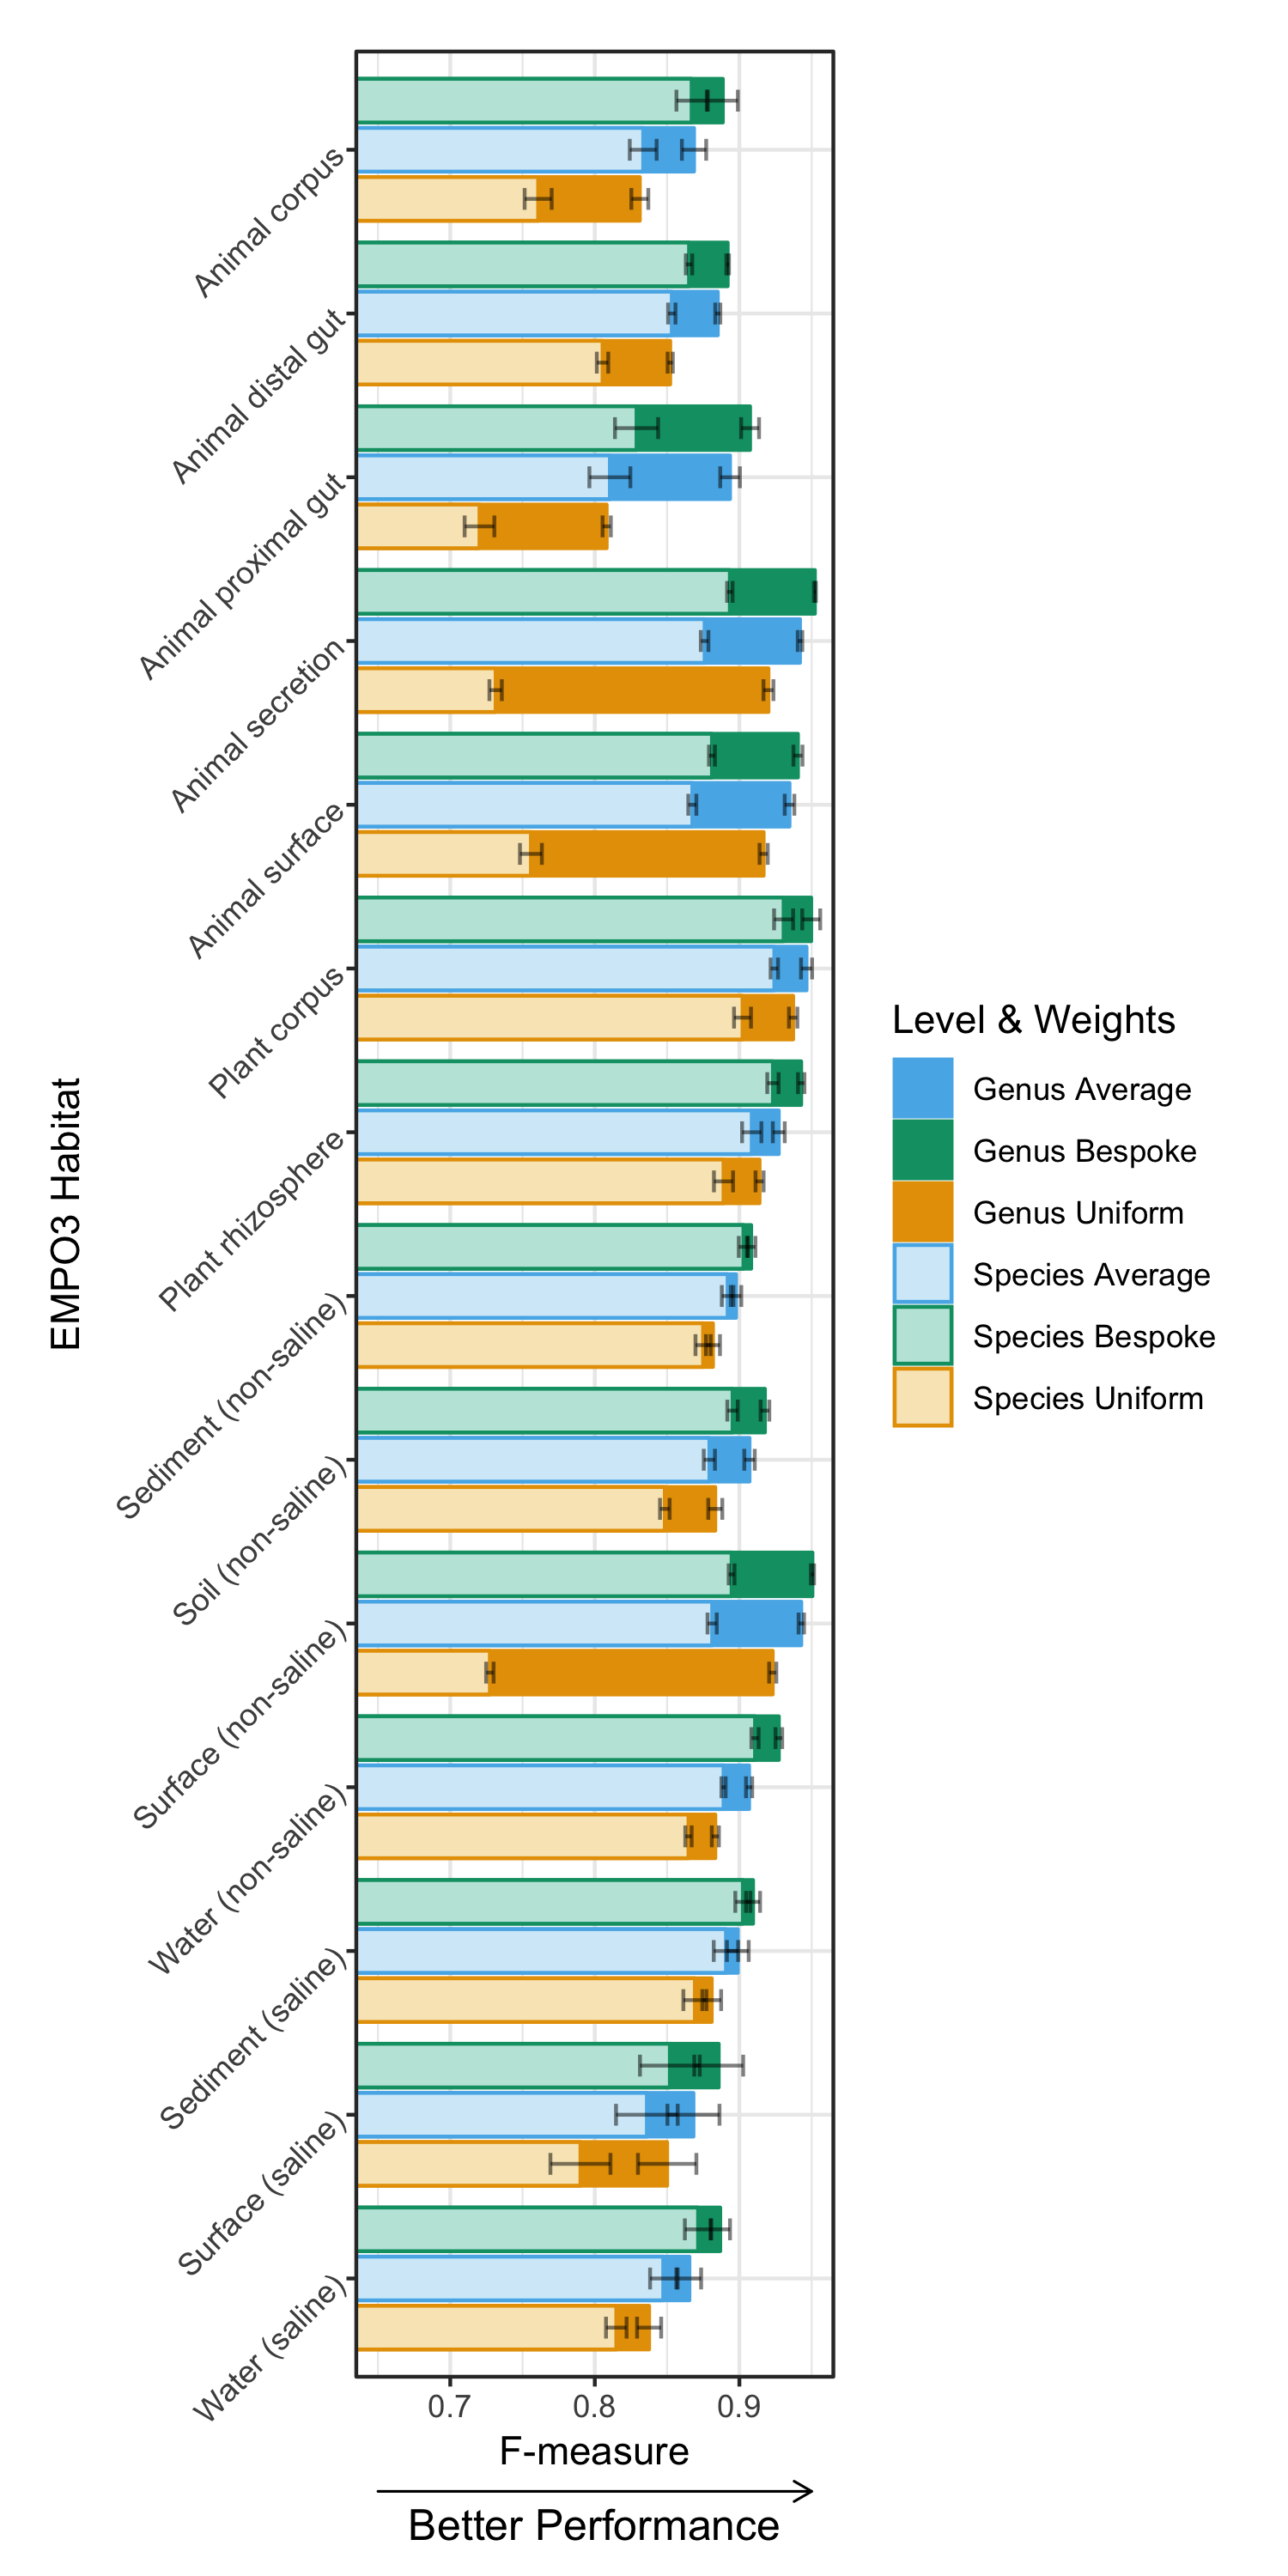

In [20]:
Image("sr-f-measure.png")

In [16]:
max(figure1['upper'] - figure1['lower'])

0.13128721225598428

In [17]:
bespoke = figure1[figure1['class weights'] == 'Bespoke']['mean']
print(min(bespoke), max(bespoke))
uniform = figure1[figure1['class weights'] == 'Uniform']['mean']
print(min(uniform), max(uniform))

0.8288638081095409 0.9305880832502146
0.720229783917639 0.9021711163046009


In [18]:
len(set(level7['sample']))

21513

In [19]:
list(set(level7['sample']))[:10]

['11113.907.36782',
 '2192.H01a.Bedroom.Floor.268.lane2.NoIndex.L002.30619',
 '550.L6S38.s.6.sequence.30395',
 '550.L4S155.s.4.sequence.30395',
 '11113.686.36782',
 '11444.H4.fecal.none.1wk.43342',
 '10308.Fh.P4.IFF.B.10.30930',
 '1883.2005.21.Crump.Artic.LTREB.main.lane4.NoIndex.30612',
 '1024.SH004.C1.RH.1.161.flw.6.11.G1.L00.28362',
 '550.L4S165.s.4.sequence.30395']

In [20]:
len(set(_id.split('.')[1] for _id in level7['sample']))

7204

In [21]:
len(set(_id.split('.')[1] for _id in level7[level7['sample type']=='surface-saline']['sample']))

58

In [35]:
grouped = level7.groupby(['sample type', 'class weights', 'fold'])
def weighted_stats(x):
    d1 = DescrStatsW(x['Recall'], weights=x['abundance'])
    return Series([d1.mean], index=['mean'])
precision = grouped.apply(weighted_stats)
precision.reset_index(inplace=True)
grouped = precision.groupby(['sample type', 'class weights'])
def weighted_stats(x):
    mu = x['mean'].mean()
    se = sem(x['mean'])
    lower, upper = t.interval(0.95, 5, mu, se)
    return Series([mu, lower, upper], index=['mean', 'lower', 'upper'])
precision = grouped.apply(weighted_stats)
precision.reset_index(inplace=True)
precision[(precision['class weights'] == 'bespoke70') | 
          (precision['class weights'] == 'uniform70')]

,sample type,class weights,mean,lower,upper
5,animal-corpus,bespoke70,0.834079,0.807420,0.860737
13,animal-corpus,uniform70,0.696828,0.671568,0.722089
21,animal-distal-gut,bespoke70,0.836902,0.830967,0.842838
29,animal-distal-gut,uniform70,0.761069,0.746696,0.775442
37,animal-proximal-gut,bespoke70,0.787296,0.752892,0.821699
45,animal-proximal-gut,uniform70,0.650310,0.628537,0.672082
53,animal-secretion,bespoke70,0.854664,0.851688,0.857641
61,animal-secretion,uniform70,0.639334,0.629122,0.649546
69,animal-surface,bespoke70,0.838421,0.831812,0.845030
77,animal-surface,uniform70,0.669983,0.647305,0.692661
